In [19]:
import glob
import os

import imageio.v3 as iio
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from miditoolkit.midi import parser as mid_parser
from miditoolkit.pianoroll import parser as pr_parser

torch.manual_seed(0)
np.random.seed(0)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

seconds = 12.8
seconds_per_pixel = 0.1
num_sequence = 10
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]
data_dir = "data/project"
image_dir = "data/images"

In [21]:
def slice_image(image, slice_size):
    num_slices = int(image.shape[1] // slice_size)

    slices = np.zeros((num_slices, image.shape[0], slice_size))
    for slice in range(num_slices):
        slices[slice] = image[:, slice * slice_size : (slice + 1) * slice_size]

    return slices

In [22]:
def convert_song_to_inputs(song: str, composer:str, slice_size:int = 128, num_sequence:int = 10):
    """Returns inputs with shape [num_inputs, sequence_length, channels, image_height, image_width]"""

    pixels_per_slice = int(seconds // seconds_per_pixel)
    sequence_length = pixels_per_slice * num_sequence

    # Load image
    # load midi file
    mido_obj = mid_parser.MidiFile(song)
    notes = []
    for instrument in mido_obj.instruments:
        notes += instrument.notes

    # convert notes to pianoroll
    pianoroll = pr_parser.notes2pianoroll(notes, pitch_range=(0, 127), resample_factor=10/mido_obj.ticks_per_beat).T

    # Pad image
    pad_width = int(np.ceil(pianoroll.shape[1] / sequence_length) * sequence_length) - pianoroll.shape[1]
    padded_image = np.pad(pianoroll, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    # Convert to input and output for network
    images = []
    outputs = []
    for pad_image in padded_image.T.reshape(-1, sequence_length, pianoroll.shape[0]):
        images.append(slice_image(pad_image.T, slice_size))
        outputs.append(composer)

    # Convert to numpy array
    inputs = np.expand_dims(np.array(images), axis=2)

    return inputs, outputs

In [23]:
inputs = []
outputs = []
for composer in COMPOSERS:
    files = [y for x in os.walk(data_dir + "/" + composer) for y in glob.glob(os.path.join(x[0], "*.mid"))]
    for file in files:
        try:
            input, output = convert_song_to_inputs(file, composer)
        except:
            print(f"Unable to load {file}. Skipping...")
            continue
        inputs.append(input)
        outputs += output

inputs = np.vstack(inputs)
inputs.shape

Unable to load data/project/Beethoven\Anhang 14-3.mid. Skipping...
Unable to load data/project/Beethoven\Symphonies\Symphony n4 1mov.mid. Skipping...
Unable to load data/project/Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid. Skipping...


(6215, 10, 1, 128, 128)

In [24]:
output_df = pd.DataFrame(outputs)
output_df.value_counts()

0        
Bach         2393
Beethoven    1740
Mozart       1589
Chopin        493
Name: count, dtype: int64

In [25]:
# Get dummies
output_df = pd.get_dummies(output_df)
output_df.head()

,0_Bach,0_Beethoven,0_Chopin,0_Mozart
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False


In [26]:
# Split into train, test, and validation
train_X, test_X, train_y, test_y = train_test_split(inputs, output_df, test_size=0.2)
test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5)

# Convert to torch tensors
train_X = torch.Tensor(train_X).to(device)
test_X = torch.Tensor(test_X).to(device)
val_X = torch.Tensor(val_X).to(device)

train_y = torch.Tensor(train_y.to_numpy().astype(int)).to(device)
test_y = torch.Tensor(test_y.to_numpy().astype(int)).to(device)
val_y = torch.Tensor(val_y.to_numpy().astype(int)).to(device)

In [27]:
# Define the model
class ComposerClassifier(nn.Module):
    """This model contains 2 CNN layers, 1 LSTM layer, and 1 fully
    connected layer. The input is expected to be of shape

        (num_inputs, sequence_length, 1, image_height, image_width)

    and the output is expected to be of shape

        (num_inputs, 4)

    where the output represents the probability of each composer out of
    Bach, Beethoven, Mozart, and Chopin respectively.

    The network will process each image in the input through the CNN
    layers and then hand each sequence of processed images to the LSTM
    layer. The output of the LSTM layer is then passed through the fully
    connected layer to generate the final probabilities using a softmax.

    """
    def __init__(self, hidden_nodes):
        super(ComposerClassifier, self).__init__()

        # Define network parameters
        self.hidden_nodes = hidden_nodes

        # Define CNN layers
        # 4 filters of size 7x3 to capture chord structure
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(7,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=3)

        # 8 filters of size 3x7 to capture melodic structure
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(3,7))
        self.pool2 = nn.MaxPool2d(kernel_size=(5,5), stride=5)

        # Define LSTM layers
        self.lstm = nn.LSTM(392, self.hidden_nodes, batch_first=True)

        # Define fully connected layer
        self.fc = nn.Linear(self.hidden_nodes, 4)


    def forward(self, x):
        # Stack all inputs and sequence tensors together
        num_inputs = x.shape[0]
        x = torch.vstack(torch.unbind(x, dim=0)).to(x.device)

        # Process them all simultaneously through the CNN layers
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))

        # Reconstruct the tensor back into sequences of (num_inputs, sequence_length, 392)
        sequence = x.reshape(num_inputs, -1, 392).to(x.device)

        # Process sequence tensor through LSTM layers
        h0 = torch.zeros(1, sequence.size(0), self.hidden_nodes).to(x.device)
        c0 = torch.zeros(1, sequence.size(0), self.hidden_nodes).to(x.device)
        out, _ = self.lstm(sequence, (h0, c0))

        # Pass output through fully connected layer
        out = self.fc(out[:, -1, :])

        # Return softmax probabilities
        return nn.functional.softmax(out, dim=1)

In [28]:
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    """Early stopping utility. Trains until the validation loss does not
    improve by at least min_delta after patience epochs.
    """
    def __init__(self, patience=1, min_delta=0):
        # Number of epochs to wait if no improvement is seen
        self.patience = patience

        # Minimum change in the monitored quantity to qualify as an improvement
        self.min_delta = min_delta

        # Internal trackers
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the validation loss has improved
        if validation_loss < self.min_validation_loss:
            # Save the best validation loss and reset the counter
            self.min_validation_loss = validation_loss
            self.counter = 0

        # If the validation loss has not improved
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # Increment the counter
            self.counter += 1

            # If the counter has reached the patience, stop training
            if self.counter >= self.patience:
                return True
        return False

In [29]:
# Training loop
def train(model, optimizer, criterion, scheduler, train_X, train_y, test_X, test_y, num_epochs=300, batch_size=32, lr=0.001, early_stopper=None) -> tuple[list, list, list]:
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []

    accuracies = []

    micro_precisions = []
    micro_recalls = []
    micro_f1s = []

    macro_precisions = []
    macro_recalls = []
    macro_f1s = []

    weighted_precisions = []
    weighted_recalls = []
    weighted_f1s = []

    # Train the model
    num_batches = int(np.ceil(len(train_X) / batch_size))
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            # Get the batch data
            batch_X = train_X[batch_size * batch:min(batch_size * (batch + 1), train_X.shape[0])]
            batch_y = train_y[batch_size * batch:min(batch_size * (batch + 1), train_X.shape[0])]

            # Forward Pass
            optimizer.zero_grad()
            output = model(batch_X)

            # Backward Pass
            train_loss = criterion(output, batch_y)
            train_loss.backward()
            optimizer.step()

        # Evaluate the model
        with torch.no_grad():
            # Forward Pass
            output = model(test_X)

            # Compute Metrics
            val_loss = criterion(output, test_y)
            correct = correct = test_y.cpu().argmax(dim=1)
            answer = output.argmax(dim=1).cpu()

            accuracy = accuracy_score(correct, answer)

            micro_precision = precision_score(correct, answer, average='micro', zero_division=0)
            micro_recall = recall_score(correct, answer, average='micro', zero_division=0)
            micro_f1 = f1_score(correct, answer, average='micro', zero_division=0)

            macro_precision = precision_score(correct, answer, average='macro', zero_division=0)
            macro_recall = recall_score(correct, answer, average='macro', zero_division=0)
            macro_f1 = f1_score(correct, answer, average='macro', zero_division=0)

            weighted_precision = precision_score(correct, answer, average='weighted', zero_division=0)
            weighted_recall = recall_score(correct, answer, average='weighted', zero_division=0)
            weighted_f1 = f1_score(correct, answer, average='weighted', zero_division=0)


            # Record Metrics
            train_losses += [train_loss.item()]
            val_losses += [val_loss.item()]

            accuracies += [accuracy]

            micro_precisions += [micro_precision]
            micro_recalls += [micro_recall]
            micro_f1s += [micro_f1]

            macro_precisions += [macro_precision]
            macro_recalls += [macro_recall]
            macro_f1s += [macro_f1]

            weighted_precisions += [weighted_precision]
            weighted_recalls += [weighted_recall]
            weighted_f1s += [weighted_f1]

            # Print Metrics
            print(f"Epoch: {epoch}, Train Loss: {train_loss.item():.3f}, Validation Loss: {val_loss.item():.3f}, LR: {scheduler.get_last_lr()[0]:.6f} Accuracy: {accuracy:.3f}",
                  f"\n\tPrecision | Micro | {micro_precision:.3f} | Macro | {macro_precision:.3f} | Weighted | {weighted_f1:.3f}",
                  f"\n\tRecall    | Micro | {micro_recall:.3f} | Macro | {macro_recall:.3f} | Weighted | {weighted_precision:.3f}",
                  f"\n\tF1        | Micro | {micro_f1:.3f} | Macro | {macro_f1:.3f} | Weighted | {weighted_recall:.3f}")

        # Check for early stopping
        if early_stopper is not None and early_stopper.early_stop(val_loss):
            print(f"Early stopped triggered at epoch: {epoch}")
            break

        # Step the scheduler
        scheduler.step()

    print("Finished Training")

    # Gather metrics to return
    precisions = (micro_precisions, macro_precisions, weighted_precisions)
    recalls = (micro_recalls, macro_recalls, weighted_recalls)
    f1s = (micro_f1s, macro_f1s, weighted_f1s)
    return train_losses, val_losses, accuracies, precisions, recalls, f1s

In [30]:
# Initialize the model and move it to the device
model = ComposerClassifier(hidden_nodes=500)
model = model.to(device)

In [31]:
# Best Parameters Found:
# - Model: Hidden Nodes (500)
# - Training: Epochs (1000) | Batch Size (64)
# - Optimizer: Adam | LR (0.0005)
# - Scheduler: Exponential LR | Gamma (0.999)
# - Early Stopper: Patience (3) | Min Delta (0.5)

# Define the loss function, optimizer, and early stopper
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
early_stopper = EarlyStopper(patience=3, min_delta=0.5)

# Begin training
train_losses, val_losses, accuracies, precisions, recalls, f1s = train(model, optimizer, criterion, scheduler, train_X, train_y, test_X, test_y, batch_size=64, num_epochs=1000, early_stopper=early_stopper)

Epoch: 0, Train Loss: 1.171, Validation Loss: 1.175, LR: 0.000050 Accuracy: 0.596 
	Precision | Micro | 0.596 | Macro | 0.437 | Weighted | 0.545 
	Recall    | Micro | 0.596 | Macro | 0.452 | Weighted | 0.543 
	F1        | Micro | 0.596 | Macro | 0.423 | Weighted | 0.596
Epoch: 1, Train Loss: 1.111, Validation Loss: 1.099, LR: 0.000050 Accuracy: 0.670 
	Precision | Micro | 0.670 | Macro | 0.484 | Weighted | 0.635 
	Recall    | Micro | 0.670 | Macro | 0.524 | Weighted | 0.607 
	F1        | Micro | 0.670 | Macro | 0.500 | Weighted | 0.670
Epoch: 2, Train Loss: 1.075, Validation Loss: 1.059, LR: 0.000050 Accuracy: 0.709 
	Precision | Micro | 0.709 | Macro | 0.515 | Weighted | 0.676 
	Recall    | Micro | 0.709 | Macro | 0.559 | Weighted | 0.647 
	F1        | Micro | 0.709 | Macro | 0.535 | Weighted | 0.709
Epoch: 3, Train Loss: 1.048, Validation Loss: 1.037, LR: 0.000050 Accuracy: 0.725 
	Precision | Micro | 0.725 | Macro | 0.528 | Weighted | 0.692 
	Recall    | Micro | 0.725 | Macro | 0.57

In [41]:
# Evaluate the model
with torch.no_grad():
    batch_size = 64
    num_batches = int(np.ceil(len(train_X) / batch_size))
    for batch in range(num_batches):
            # Get the batch data
            batch_X = train_X[batch_size * batch:min(batch_size * (batch + 1), train_X.shape[0])]
            batch_y = train_y[batch_size * batch:min(batch_size * (batch + 1), train_X.shape[0])]

            # Forward Pass
            optimizer.zero_grad()
            output = model(batch_X)

            if batch == 0:
                outputs = output
            else:
                outputs = torch.vstack((outputs, output))

    # Compute Metrics
    correct = train_y.cpu().argmax(dim=1)
    answer = outputs.argmax(dim=1).cpu()

    accuracy = accuracy_score(correct, answer)

    micro_precision = precision_score(correct, answer, average='micro', zero_division=0)
    micro_recall = recall_score(correct, answer, average='micro', zero_division=0)
    micro_f1 = f1_score(correct, answer, average='micro', zero_division=0)

    macro_precision = precision_score(correct, answer, average='macro', zero_division=0)
    macro_recall = recall_score(correct, answer, average='macro', zero_division=0)
    macro_f1 = f1_score(correct, answer, average='macro', zero_division=0)

    weighted_precision = precision_score(correct, answer, average='weighted', zero_division=0)
    weighted_recall = recall_score(correct, answer, average='weighted', zero_division=0)
    weighted_f1 = f1_score(correct, answer, average='weighted', zero_division=0)

    # Print Metrics
    print(f"Training Set: Accuracy: {accuracy:.3f}",
            f"\n\tPrecision | Micro | {micro_precision:.3f} | Macro | {macro_precision:.3f} | Weighted | {weighted_f1:.3f}",
            f"\n\tRecall    | Micro | {micro_recall:.3f} | Macro | {macro_recall:.3f} | Weighted | {weighted_precision:.3f}",
            f"\n\tF1        | Micro | {micro_f1:.3f} | Macro | {macro_f1:.3f} | Weighted | {weighted_recall:.3f}")

Training Evaluation: Accuracy: 0.983 
	Precision | Micro | 0.983 | Macro | 0.982 | Weighted | 0.983 
	Recall    | Micro | 0.983 | Macro | 0.980 | Weighted | 0.983 
	F1        | Micro | 0.983 | Macro | 0.981 | Weighted | 0.983


In [33]:
# Evaluate the model
with torch.no_grad():
    # Forward Pass
    output = model(val_X)

    # Compute Metrics
    correct = val_y.cpu().argmax(dim=1)
    answer = output.argmax(dim=1).cpu()

    accuracy = accuracy_score(correct, answer)

    micro_precision = precision_score(correct, answer, average='micro', zero_division=0)
    micro_recall = recall_score(correct, answer, average='micro', zero_division=0)
    micro_f1 = f1_score(correct, answer, average='micro', zero_division=0)

    macro_precision = precision_score(correct, answer, average='macro', zero_division=0)
    macro_recall = recall_score(correct, answer, average='macro', zero_division=0)
    macro_f1 = f1_score(correct, answer, average='macro', zero_division=0)

    weighted_precision = precision_score(correct, answer, average='weighted', zero_division=0)
    weighted_recall = recall_score(correct, answer, average='weighted', zero_division=0)
    weighted_f1 = f1_score(correct, answer, average='weighted', zero_division=0)

    # Print Metrics
    print(f"Evaluation Set: Accuracy: {accuracy:.3f}",
            f"\n\tPrecision | Micro | {micro_precision:.3f} | Macro | {macro_precision:.3f} | Weighted | {weighted_f1:.3f}",
            f"\n\tRecall    | Micro | {micro_recall:.3f} | Macro | {macro_recall:.3f} | Weighted | {weighted_precision:.3f}",
            f"\n\tF1        | Micro | {micro_f1:.3f} | Macro | {macro_f1:.3f} | Weighted | {weighted_recall:.3f}")

Evaluation: Accuracy: 0.836 
	Precision | Micro | 0.836 | Macro | 0.819 | Weighted | 0.834 
	Recall    | Micro | 0.836 | Macro | 0.788 | Weighted | 0.834 
	F1        | Micro | 0.836 | Macro | 0.801 | Weighted | 0.836


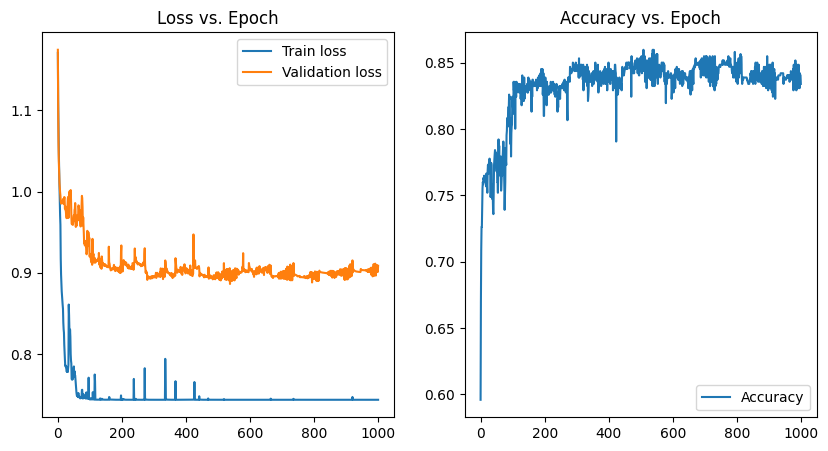

In [ ]:
# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss vs. Epoch")
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.title("Accuracy vs. Epoch")
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.show()

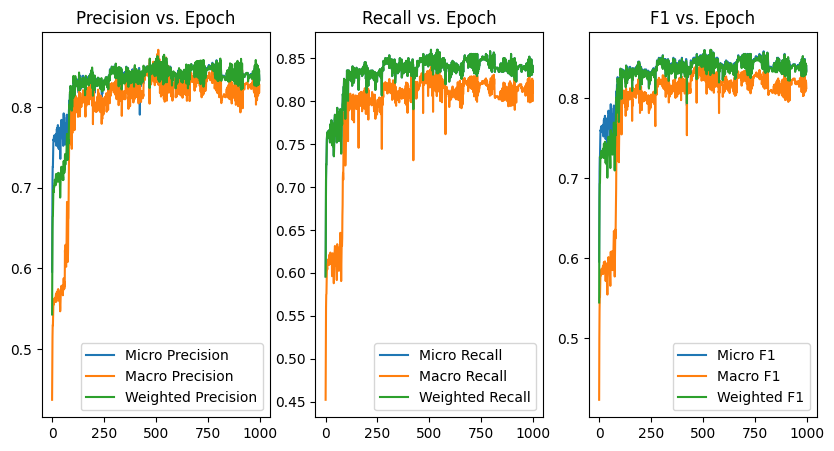

In [ ]:
# Plot Precisions
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Precision vs. Epoch")
plt.plot(precisions[0], label='Micro Precision')
plt.plot(precisions[1], label='Macro Precision')
plt.plot(precisions[2], label='Weighted Precision')
plt.legend()

# Plot Recalls
plt.subplot(1, 3, 2)
plt.title("Recall vs. Epoch")
plt.plot(recalls[0], label='Micro Recall')
plt.plot(recalls[1], label='Macro Recall')
plt.plot(recalls[2], label='Weighted Recall')
plt.legend()

# Plot F1
plt.subplot(1, 3, 3)
plt.title("F1 vs. Epoch")
plt.plot(f1s[0], label='Micro F1')
plt.plot(f1s[1], label='Macro F1')
plt.plot(f1s[2], label='Weighted F1')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix as Percentage')

<Figure size 1000x500 with 0 Axes>

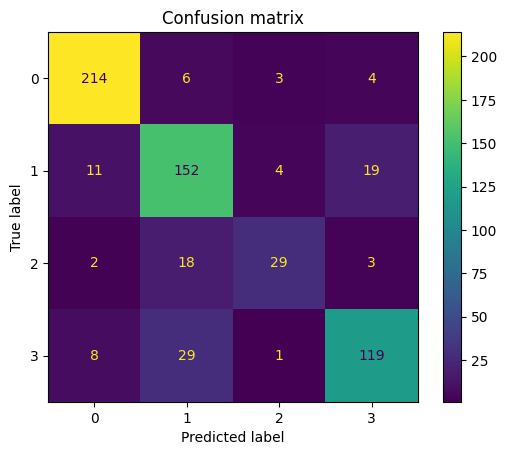

<Figure size 1000x500 with 0 Axes>

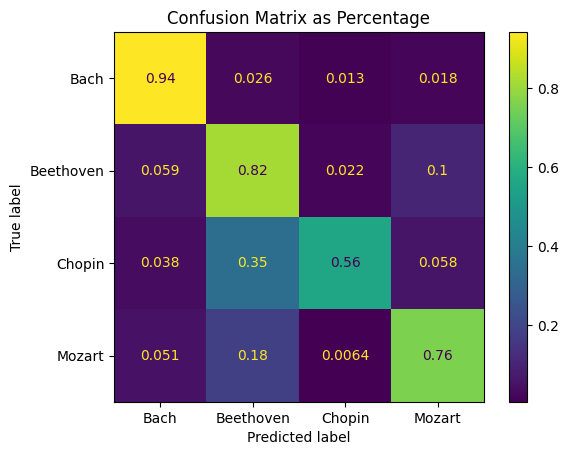

In [ ]:
# Create Regular Confusion Matrix
plt.figure(figsize=(10, 5))
y_pred = torch.argmax(model(test_X), dim=1)
ConfusionMatrixDisplay.from_predictions(val_y.argmax(dim=1).cpu(), y_pred.cpu())
plt.title("Confusion matrix")

# Create Confusion Matrix as Percentage
plt.figure(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(val_y.argmax(dim=1).cpu(), y_pred.cpu(), display_labels=COMPOSERS, normalize='true')
plt.title("Confusion Matrix as Percentage")

In [ ]:
torch.onnx.export(model, test_X[0].reshape((1, 10, 1, 128, 128)), "pytorch_model.onnx", input_names=["pianoroll image sequence"], output_names=["composer probabilities"])

d:\My Stuff\School\MSAAI\AAI 511\Final Project\venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
